# Linear Regression and Linear Gradient Descent Approximation

© MIT Kevin Patel

This is an extension on a previous notebook (linear_reg.ipynb) that applied linear regression to three data sets. This notebook contains all of the code from that notebook with the addition of gradient descent linear approximators that provide additional comparison points.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib

## Defining Linear Regression

Using least squares error minimization, we end up with a system of linear equations with the form:
$\textbf{D}^T(\vec{y}-\textbf{D}*\vec{w})=0$, where $D$ is the data matrix (where the first column vector is a constant '1' for the bias input), $\vec{w}$ is the weight vector (where the first element is the bias term), and $\vec{y}$ is the vector of labels.

The expression $\textbf{D}*\vec{w}$ represents the model estimate vector $\hat{y}$, thus $(\vec{y}-\textbf{D}*\vec{w})$ is the vector of residuals for the model.

In [2]:
def linear_regression(feature_df, label_series):
    assert(feature_df.shape[0] == label_series.shape[0])
    
    #Convert to matrix and add bias input to first column
    feature_mat = np.insert(np.matrix(feature_df), 0, 1, axis=1) 
    
    #Transpose to turn label_vec into a column vector
    label_vec = np.matrix(label_series).transpose() 

    #Minimize least squares
    weights = np.linalg.inv(feature_mat.transpose() * feature_mat) * feature_mat.transpose() * label_vec

    return weights

### A Couple of Performance Metrics

Sum squared error (SSE) is defined as the sum of square of the residuals. The residuals are the actual minus predicted value of the target (ie the error):
$SSE = \sum{(y - \hat{y}})^{2}$

where $y$ is the target sample value, $\hat{y}$ is the predicted target value

In [3]:
def sum_squared_error(predicted, actual):
    residuals = np.subtract(actual, predicted)
    return np.sum(np.power(residuals, 2))

The $r^{2}$ is defined as one minus the sum squared error divided by the sum squared of the target (label) values minus the target sample mean:

$r^{2} = 1 - \frac{SSE}{\sum{(y - \bar{y}})^{2}} = 1 - \frac{\sum{(y - \hat{y}})^{2}}{\sum{(y - \bar{y}})^{2}}$

where $y$ is the target sample value, $\hat{y}$ is the predicted target value, and $\bar{y}$ is the target sample mean

In [4]:
def r_squared(predicted, actual):
    ss_res = sum_squared_error(predicted, actual)
    ss_tot = np.sum(np.power(np.subtract(actual, actual.mean()), 2))
    return 1 - (ss_res / ss_tot)

### Sanity Check: Regress a simple linear function

The basic linear regression algorithm with a sum squared error cost function is computationally fairly simple, but nevertheless I wrote a simple test for it below (regression  of $y = 2x + 5$):

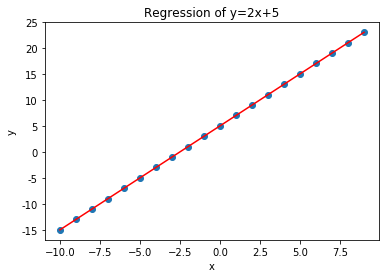

In [5]:
%matplotlib inline
example = pd.DataFrame({ 'x' : range(-10, 10 , 1) })
example['f(x)'] = example['x'].map(lambda x: 2 * x + 5)

dependent_vars = ['x']
feats = example[dependent_vars]
lab = example['f(x)']
weights = linear_regression(feats, lab)      #Compute linear regression weights

xrange = np.matrix(np.linspace(min(feats.values), max(feats.values), 3)).transpose()
xrange = np.insert(xrange, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange.shape[1] ==  weights.shape[0]) #Assert correct dimensioning for dot product

plt.title('Regression of y=2x+5')
plt.xlabel(dependent_vars[0])
plt.ylabel('y')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.scatter(feats, lab)
plt.plot(xrange[:, 1], xrange * weights, 'red');

In [6]:
feat_mat = np.insert(np.matrix(feats), 0, 1, axis=1) # Add bias input
predicted = feat_mat * weights
r2 = r_squared(np.asarray(predicted.transpose())[0], np.array(lab))
print('r squared is correct:', r2==1)

r squared is correct: True


### Scikit-learn comparison

In [7]:
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats, lab)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
sc_linear_predictions = feat_mat * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab), np.array(sc_linear_predictions).transpose()[0])
print('scikit-learn predicted r squared {:0.4f}'.format(sc_linear_r2))

scikit-learn predicted r squared 1.0000


## Defining Gradient Descent

Gradient descent is an iterative optimization algorithm used to find the minimum value of an objective function, $E$. It, along with the function maximizing variant gradient ascent, are extremely important for machine learning. The reason this algorithm is so important is because of how we define problems in machine learning.

As we know, given an $n \times m$ matrix of data $\textbf{D}$ (where there $m$ rows of training observations and $n$ columns of features) and a $m \times 1$ vector of labels $\vec{y}$, we are attempting to find the estimator function: $\hat{y}(\vec{x})$ that is parameterized by $\vec{\theta}$. For example in the linear regression case $\vec{\theta}=\vec{w}$, where $\vec{w}$ is the vector of linear weights. At a high level, gradient descent works by iteratively moving the vector of parameters $\vec{\theta}$ in the opposite direction of the derivative of the objective function $\frac{\partial E}{\partial \vec{\theta}}$. This direction is known as the gradient, written $\nabla\vec{\theta}$.

In practice we do not merely update the parameters by this unscaled gradient. We scale $\nabla\vec{\theta}$ by a learning rate hyperparameter $\eta$, so that our delta is $\Delta\vec{\theta}=-\eta\nabla\vec{\theta}$. The reason we scale the gradient is so that we can control the rate of convergence. A $\eta$ that is too small will cause the model to converge very slowly, a $\eta$ that is too large will "overshoot" a global or local optima and not converge at all. Thus our final update rule is:

$\vec{\theta}=\vec{\theta}+\Delta\vec{\theta}$

$\vec{\theta}=\vec{\theta}-\eta\nabla\vec{\theta}$

as we iterate through training examples.

The nature of the $n \times 1$ vector of parameters $\vec{\theta}$ is dependent on the model we use. Gradient descent is powerful because it can be applied to find $\vec{\theta}$ for any model where we can differentiate the objective (cost) function with respect to $\vec{\theta}$ (ie find the gradient $\nabla\vec{\theta} = \frac{\partial E}{\partial \vec{\theta}}$). To name an example, feedforward neural networks adhere to this condition. Below we will explore the basic gradient descent algorithm applied to the linear regression model, but keep in mind this method of finding model parameters can be applied to many other learning models.

### Training a Linear Model with Gradient Descent

Applied to the linear case, the vector of parameters is a vector of linear weights ($\vec{\theta}=\vec{w}$). We know from the previous definition of the linear regression problem that we can estimate the $m \times 1$ label vector $\vec{y}$ with $\hat{y} = \textbf{D}*\vec{w}$.

At each step of gradient descent, we attempt to find the gradient $\nabla\vec{w}$ vector (the appropriate weight change in response to a training example). As we already know:

$\nabla\vec{w} = \frac{\partial E}{\partial \vec{w}}$

We also know that:

$\frac{\partial E}{\partial \vec{w}} = \frac{\partial E}{\partial e} * \frac{\partial e}{\partial \hat{y}} * \frac{\partial \hat{y}}{\partial \vec{w}}$

Using a one-half sum squared error objective function with a residual error function, $E=\frac{1}{2}e^2$ and $e=y-\hat{y}$, we have:

$\frac{\partial E}{\partial y}=e$

$\frac{\partial e}{\partial \hat{y}}=-1$

For the third term, we know that for this linear model $\hat{y}$ is just the linear combination of the input and weights $\hat{y}=\vec{x}*\vec{w}$, where $\vec{x}$ is the ith row vector (ith training example) in $\textbf{D}$, so:

$\frac{\partial \hat{y}}{\partial \vec{w}}=\vec{x}$

(Note we are including the bias weight in the weight vector, so a 1 is inserted at the corresponding index in $\vec{x}$).

Thus we have:

$\nabla\vec{w}=\frac{\partial E}{\partial \vec{w}} = -e*\vec{x}$

and

$\Delta\vec{w}=-\eta(-e*\vec{x})=\eta*e*\vec{x}$

and so

$\vec{w}=\vec{w}+\eta*e*\vec{x}$

We need one more change to have standard gradient descent which updates after each pass through the entire training set of $m$ entries:

$\vec{w}=\vec{w}+\eta*\sum_{i=1}^{m} e*\vec{x}$

In the ordinary case we sum the gradients of each training example to obtain the update rule. One last piece to add is the stopping/convergence criteria. This can vary depending on how you want the model to be tuned. In our case we will stop when any of the following conditions holds:
- total squared error is below a specified threshold and difference in squared error is below a threshold across iterations
- the number of iterations exceeds a threshold value.

Let's see how this looks in code:

In [8]:
def linear_gradient_descent(feature_df, label_series, learning_rate, epsilon=.001, epsilon_delta=.00001, max_iter=1000):
    assert(feature_df.shape[0] == label_series.shape[0])

    num_examples = feature_df.shape[0]  #Number of training examples
    num_dim = feature_df.shape[1] + 1   #Number of dimensions = Number of features + 1 (for bias)

    feature_mat = np.insert(np.matrix(feature_df), 0, 1, axis=1) #Convert to matrix and add bias input to first column
    label_vec = np.matrix(label_series).transpose()  #Transpose to turn label_vec into a column vector
    weights = np.matrix(np.zeros((num_dim, 1)))
    prev_sse = 0
    sse_diff = 10 * epsilon_delta
    count = 0

    #Gradient Descent loop:
    while ((prev_sse >= epsilon or sse_diff >= epsilon_delta) and count < max_iter):
        predicted = feature_mat * weights
        residuals = np.repeat(np.subtract(label_vec, predicted), num_dim, axis=1) #Repeat residual scalar across columns
        gradients = np.multiply(residuals, feature_mat) #Elementwise multiply (e * x for all x training examples)
        gradient = np.sum(gradients, axis=0).transpose() #Get final gradient by summing gradients of each training example
        weights = weights + np.multiply(learning_rate, gradient)

        predicted = feature_mat * weights
        this_sse = .5 * sum_squared_error(predicted, label_vec)
        sse_diff = this_sse - prev_sse
        prev_sse = this_sse
        count += 1

    print(count, 'iterations')
    return weights

Notice how in the gradient descent loop we get the predicted values (using matrix operations) of all feature vectors to compute the gradient in each iteration. We repeat this exact process over the same data until our weights give a sum squared error below the threshold. Below, lets do the simple test regression from the linear regression segment above:

311 iterations
[[ 4.99013636  1.99984829]]
intercept difference from actual: 0.0099
weight difference from actual: 0.0002


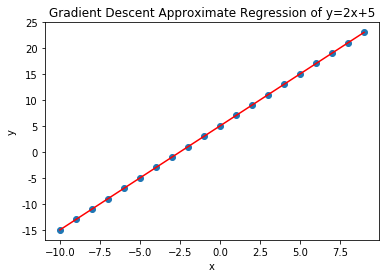

In [9]:
%matplotlib inline
example = pd.DataFrame({ 'x' : range(-10, 10 , 1) })
example['f(x)'] = example['x'].map(lambda x: 2 * x + 5)

dependent_vars = ['x']
feats = example[dependent_vars]
lab = example['f(x)']
weights = linear_gradient_descent(feats, lab, .001, epsilon=.001, epsilon_delta=.00001)      #Compute linear regression weights

xrange = np.matrix(np.linspace(min(feats.values), max(feats.values), 3)).transpose()
xrange = np.insert(xrange, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange.shape[1] ==  weights.shape[0]) #Assert correct dimensioning for dot product

plt.title('Gradient Descent Approximate Regression of y=2x+5')
plt.xlabel(dependent_vars[0])
plt.ylabel('y')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.scatter(feats, lab)
plt.plot(xrange[:, 1], xrange * weights, 'red');
print(weights.transpose())
print('intercept difference from actual: {:.4f}'.format(float(5 - weights[0])))
print('weight difference from actual: {:.4f}'.format(float(2 - weights[1])))

## Stochastic Gradient Descent (SGD)

### Standard Linear SGD

Here we'll also define a linear stochastic gradient descent (SGD) approximation function. This is identical to ordinary gradient descent, except that in each iteration the parameters are updated using less than the full $m$-length training set. In practice SGD is a much more prevalent algorithm than standard gradient descent, partly because of its faster convergence on larger data sets. The stochastic nature comes from the fact that a $k$ sized sample of training examples are randomly chosen, and the gradient is updated from these at each step:

In [10]:
def linear_sgd(feature_df, label_series, learning_rate, mini_batch_size, epsilon=.001, epsilon_delta=.00001, max_iter=100000):
    assert(feature_df.shape[0] == label_series.shape[0])

    num_examples = feature_df.shape[0]  #Number of training examples
    num_dim = feature_df.shape[1] + 1   #Number of dimensions = Number of features + 1 (for bias)
    
    assert(mini_batch_size < num_examples)

    feature_mat = np.insert(np.matrix(feature_df), 0, 1, axis=1) #Convert to matrix and add bias input to first column
    label_vec = np.matrix(label_series).transpose()  #Transpose to turn label_vec into a column vector
    weights = np.matrix(np.zeros((num_dim, 1)))
    prev_sse = 0
    sse_diff = 10 * epsilon_delta
    count = 0

    #Stochastic Gradient Descent loop:
    while ((prev_sse >= epsilon or sse_diff >= epsilon_delta) and count < max_iter):
        sample = np.random.choice(num_examples, mini_batch_size, replace=False)
        minibatch_feat = feature_mat[sample]
        minibatch_lab = label_vec[sample]
        predicted = minibatch_feat * weights
        residuals = np.repeat(np.subtract(minibatch_lab, predicted), num_dim, axis=1) #Repeat residual scalar across columns
        gradients = np.multiply(residuals, minibatch_feat) #Elementwise multiply (e * x for all x vectors in minibatch)
        gradient = np.sum(gradients, axis=0).transpose() #Get final gradient by summing gradients of minibatch
        weights = weights + np.multiply(learning_rate, gradient)

        predicted = feature_mat * weights
        this_sse = .5 * sum_squared_error(predicted, label_vec) #SSE is still computed over the whole training set
        sse_diff = this_sse - prev_sse
        prev_sse = this_sse
        count += 1

    print(count, 'iterations')
    return weights

Lets test it below:

1478 iterations
[[ 4.99684135  1.99993509]]
intercept difference from actual: 0.0032
weight difference from actual: 0.0001


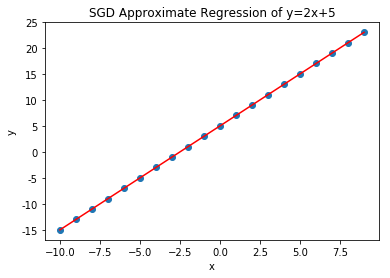

In [11]:
%matplotlib inline
example = pd.DataFrame({ 'x' : range(-10, 10 , 1) })
example['f(x)'] = example['x'].map(lambda x: 2 * x + 5)

dependent_vars = ['x']
feats = example[dependent_vars]
lab = example['f(x)']
weights = linear_sgd(feats, lab, .001, 5, epsilon=.0001, epsilon_delta=.00001)      #Compute linear regression weights
xrange = np.matrix(np.linspace(min(feats.values), max(feats.values), 3)).transpose()
xrange = np.insert(xrange, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange.shape[1] ==  weights.shape[0]) #Assert correct dimensioning for dot product

plt.title('SGD Approximate Regression of y=2x+5')
plt.xlabel(dependent_vars[0])
plt.ylabel('y')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.scatter(feats, lab)
plt.plot(xrange[:, 1], xrange * weights, 'red');
print(weights.transpose())
print('intercept difference from actual: {:.4f}'.format(float(5 - weights[0])))
print('weight difference from actual: {:.4f}'.format(float(2 - weights[1])))

### Adaptive Learning Rate with RMSProp

The RMSProp algorithm was developed by the prominent deep learning researcher Geoffrey Hinton. It is a modification of the adaptive learning rate algorithm AdaGrad which swaps out the latter's gradient accumulation for an exponentially weighted moving average. Like AdaGrad it takes previous gradients into account with an accumulator, but unlike AdaGrad it weights older gradients much less than more recent ones. The core insight of RMSProp that was taken from AdaGrad is that it scale the gradient by an adaptive vector instead of a simple learning rate scalar $\eta$:

$\frac{\eta}{\sqrt{\delta+\vec{r}}}$

In the above $\eta$ is now the "global learning rate" ($\delta$ is a constant to stabilize division by small numbers). The vector $\vec{r}$ is called the squared gradient accumulator. It is the only term in the above term that is adaptive (ie changes in each iteration). At the start of RMSProp it is initialized to all zeros with the same shape as the gradient vector.

The steps the RMSProp algorithm goes through are as follows:

* The RMSProp algorithm computes the gradient according to a randomly samped minibatch (same as SGD).
* Next, the squared gradient accumulator is updated:

$\vec{r} = \rho\vec{r} + (1 - \rho)\nabla\vec{w}\circ\nabla\vec{w}$

where $\rho$ is a constant called the decay rate (a lower value causes older gradients to be weighted less in the exponentially weighted MA accumulator), and '$\circ$' is elementwise multiplication (Hadamard product)

* Finally the weight update happens according to the adaptive learning rate ($\frac{\eta}{\sqrt{\delta+\vec{r}}}$):

$\Delta\vec{w}=-\frac{\eta}{\sqrt{\delta+\vec{r}}}\nabla\vec{w}$

and so finally we have the update rule:

$\vec{w}=\vec{w}-\frac{\eta}{\sqrt{\delta+\vec{r}}}\nabla\vec{w}$

* The process repeates until convergence as in SGD

RMSProp is generally able to perform better and converge quicker on nonconvex problems compared to AdaGrad. In fact, RMSProp is a commonly used adaptive learning algorithm for deep neural networks because it tends to result in quick convergence on a wide range of problems:

In [12]:
def linear_rms_prop(feature_df, label_series, global_learning_rate, mini_batch_size, decay_rate=.001,
                    epsilon=.001, epsilon_delta=.00001, max_iter=10000):
    assert(feature_df.shape[0] == label_series.shape[0])

    num_examples = feature_df.shape[0]  #Number of training examples
    num_dim = feature_df.shape[1] + 1   #Number of dimensions = Number of features + 1 (for bias)
    delta = 10 ** -6

    assert(mini_batch_size < num_examples)

    feature_mat = np.insert(np.matrix(feature_df), 0, 1, axis=1) #Convert to matrix and add bias input to first column
    label_vec = np.matrix(label_series).transpose()  #Transpose to turn label_vec into a column vector
    weights = np.matrix(np.zeros((num_dim, 1)))
    accumulation_vector = np.matrix(np.zeros((num_dim, 1))) #RMSProp squared gradient accumulator
    prev_sse = 0
    sse_diff = 10 * epsilon_delta
    count = 0

    while ((prev_sse >= epsilon or sse_diff >= epsilon_delta) and count < max_iter):
        sample = np.random.choice(num_examples, mini_batch_size, replace=False)
        minibatch_feat = feature_mat[sample]
        minibatch_lab = label_vec[sample]
        predicted = minibatch_feat * weights
        residuals = np.repeat(np.subtract(minibatch_lab, predicted), num_dim, axis=1) #Repeat residual scalar across columns
        gradients = np.multiply(residuals, minibatch_feat) #Elementwise multiply (e * x for all x vectors in minibatch)
        gradient = np.sum(gradients, axis=0).transpose()   #Get final gradient by summing gradients of minibatch
    
        #Accumulate exponential weighted squared gradient
        accumulation_vector = np.multiply(decay_rate, accumulation_vector) + np.multiply(1 - decay_rate, np.square(gradient))
        #Compute decay factors
        exponential_decay_factors = np.divide(global_learning_rate, np.sqrt(np.add(delta, accumulation_vector)))
        #Scale gradient by exponential decay (exponential moving average) in update
        weights = weights + np.multiply(exponential_decay_factors, gradient)

        predicted = feature_mat * weights
        this_sse = .5 * sum_squared_error(predicted, label_vec) #SSE is still computed over the whole training set
        sse_diff = this_sse - prev_sse
        prev_sse = this_sse
        count += 1

    print(count, 'iterations')
    return weights

5284 iterations
[[ 4.99987423  2.00041184]]
intercept difference from actual: 0.0001
weight difference from actual: -0.0004


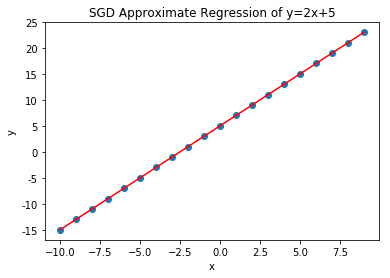

In [13]:
%matplotlib inline
example = pd.DataFrame({ 'x' : range(-10, 10 , 1) })
example['f(x)'] = example['x'].map(lambda x: 2 * x + 5)

dependent_vars = ['x']
feats = example[dependent_vars]
lab = example['f(x)']
weights = linear_rms_prop(feats, lab, .001, 5, decay_rate=.001, epsilon=.0001, epsilon_delta=.0001)
xrange = np.matrix(np.linspace(min(feats.values), max(feats.values), 3)).transpose()
xrange = np.insert(xrange, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange.shape[1] ==  weights.shape[0]) #Assert correct dimensioning for dot product

plt.title('SGD Approximate Regression of y=2x+5')
plt.xlabel(dependent_vars[0])
plt.ylabel('y')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.scatter(feats, lab)
plt.plot(xrange[:, 1], xrange * weights, 'red');
print(weights.transpose())
print('intercept difference from actual: {:.4f}'.format(float(5 - weights[0])))
print('weight difference from actual: {:.4f}'.format(float(2 - weights[1])))

## Univariate Linear Regression
### [US Real GDP Regressed on Time Since 1947](https://fred.stlouisfed.org/series/GDPC1)

The following is the real GDP of the United States since 1947, released by the Federal Reserve Bank of St. Louis. The US GDP follows a reasonably strong linear relationship with time, so that is what we'll visualize here:

In [14]:
table1 = pd.read_csv('./data/GDPC1.csv')
table1.insert(1, 'Quarters Since 1947', range(len(table1['DATE'])))
print(len(table1), 'rows total')
table1.head()

280 rows total


,DATE,Quarters Since 1947,GDPC1
0,1947-01-01,0,1934.5
1,1947-04-01,1,1932.3
2,1947-07-01,2,1930.3
3,1947-10-01,3,1960.7
4,1948-01-01,4,1989.5


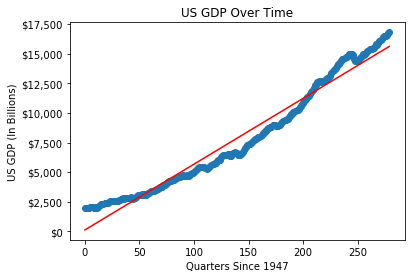

In [15]:
%matplotlib inline
dependent_vars1 = ['Quarters Since 1947']
feats1 = table1[dependent_vars1]
lab1 = table1['GDPC1']
weights1 = linear_regression(feats1, lab1)      #Compute linear regression weights

xrange1 = np.matrix(np.linspace(min(feats1.values), max(feats1.values), 3)).transpose()
xrange1 = np.insert(xrange1, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange1.shape[1] ==  weights1.shape[0]) #Assert correct dimensioning for dot product

plt.title('US GDP Over Time')
plt.xlabel(dependent_vars1[0])
plt.ylabel('US GDP (In Billions)')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

plt.scatter(feats1, lab1)
plt.plot(xrange1[:, 1], xrange1 * weights1, 'red');

There is a definite linear relationship between the US GDP and time. By looking at the regression coefficient we can see by how much the linear regression estimates the GDP will increase per quarter:

In [16]:
print('Predicted increase in GDP since 1947 is', '${:0.3f}'.format(weights1.item(1, 0)), 'billion per quarter.')
print('weights:', weights1.transpose())

Predicted increase in GDP since 1947 is $55.539 billion per quarter.
weights: [[ 121.69439248   55.53928495]]


In [17]:
feat_mat1 = np.insert(np.matrix(feats1), 0, 1, axis=1) # Add bias input
predicted1 = feat_mat1 * weights1
r2 = r_squared(np.asarray(predicted1.transpose())[0], np.array(lab1))
sse = sum_squared_error(np.asarray(predicted1.transpose())[0], np.array(lab1))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table1)))

r squared is 0.9641
sum squared error is 209923420.7226
mean squared error is 749726.5026


### Scikit-learn comparison

In [18]:
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats1, lab1)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
sc_linear_predictions = feat_mat1 * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab1), np.array(sc_linear_predictions).transpose()[0])
print('scikit-learn predicted r squared: {:0.4f}'.format(sc_linear_r2))

scikit-learn predicted r squared: 0.9641


### Gradient Descent

1000 iterations
weights: [[  1.15285305  56.18620465]]
r squared is 0.9640
sum squared error is 210945997.7098
mean squared error is 753378.5632


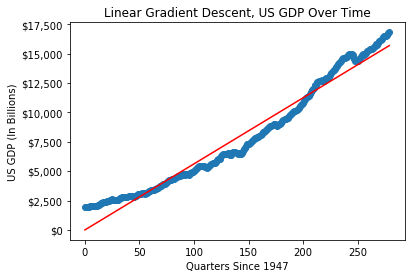

In [19]:
%matplotlib inline
weights1_lgd = linear_gradient_descent(feats1, lab1, .0000001, epsilon=.001, epsilon_delta=.00001, max_iter=1000)
print('weights:', weights1_lgd.transpose())
feat_mat1 = np.insert(np.matrix(feats1), 0, 1, axis=1) # Add bias input
predicted1 = feat_mat1 * weights1_lgd
r2 = r_squared(np.asarray(predicted1.transpose())[0], np.array(lab1))
sse = sum_squared_error(np.asarray(predicted1.transpose())[0], np.array(lab1))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table1)))

xrange1 = np.matrix(np.linspace(min(feats1.values), max(feats1.values), 3)).transpose()
xrange1 = np.insert(xrange1, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange1.shape[1] ==  weights1_lgd.shape[0]) #Assert correct dimensioning for dot product

plt.title('Linear Gradient Descent, US GDP Over Time')
plt.xlabel(dependent_vars1[0])
plt.ylabel('US GDP (In Billions)')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

plt.scatter(feats1, lab1)
plt.plot(xrange1[:, 1], xrange1 * weights1_lgd, 'red');

### Stochastic Gradient Descent (SGD)

Notably, SGD yeilds comparable error to standard gradient descent going through a tenth of the examples (28,000 vs 280,000):

1000 iterations
weights: [[  0.38224211  55.99139096]]
r squared is 0.9639
sum squared error is 211247172.3908
mean squared error is 754454.1871


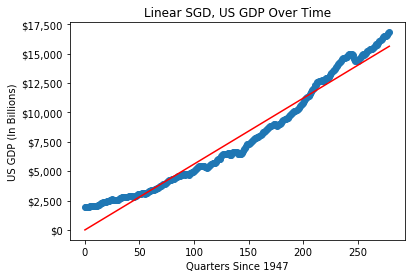

In [20]:
%matplotlib inline
weights1_lsgd = linear_sgd(feats1, lab1, .0000001, int(len(table1)/10), epsilon=50*(10**6), epsilon_delta=.01, max_iter=1000)
print('weights:', weights1_lsgd.transpose())
feat_mat1 = np.insert(np.matrix(feats1), 0, 1, axis=1) # Add bias input
predicted1 = feat_mat1 * weights1_lsgd
r2 = r_squared(np.asarray(predicted1.transpose())[0], np.array(lab1))
sse = sum_squared_error(np.asarray(predicted1.transpose())[0], np.array(lab1))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table1)))

xrange1 = np.matrix(np.linspace(min(feats1.values), max(feats1.values), 3)).transpose()
xrange1 = np.insert(xrange1, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange1.shape[1] ==  weights1_lsgd.shape[0]) #Assert correct dimensioning for dot product

plt.title('Linear SGD, US GDP Over Time')
plt.xlabel(dependent_vars1[0])
plt.ylabel('US GDP (In Billions)')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

plt.scatter(feats1, lab1)
plt.plot(xrange1[:, 1], xrange1 * weights1_lsgd, 'red');

### RMSProp

RMSProp converges even faster (about 15,500 training examples to convergence with comparable error):

550 iterations
weights: [[ 54.73821402  54.74348167]]
r squared is 0.9624
sum squared error is 219950531.2406
mean squared error is 785537.6116


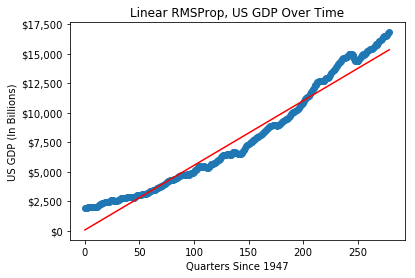

In [21]:
%matplotlib inline
weights1_rms_prop = linear_rms_prop(feats1, lab1, .1, int(len(table1)/10), decay_rate=.01,
                                    epsilon=110*(10**6), epsilon_delta=.001, max_iter=10000)
print('weights:', weights1_rms_prop.transpose())
feat_mat1 = np.insert(np.matrix(feats1), 0, 1, axis=1) # Add bias input
predicted1 = feat_mat1 * weights1_rms_prop
r2 = r_squared(np.asarray(predicted1.transpose())[0], np.array(lab1))
sse = sum_squared_error(np.asarray(predicted1.transpose())[0], np.array(lab1))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table1)))

xrange1 = np.matrix(np.linspace(min(feats1.values), max(feats1.values), 3)).transpose()
xrange1 = np.insert(xrange1, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange1.shape[1] ==  weights1_rms_prop.shape[0]) #Assert correct dimensioning for dot product

plt.title('Linear RMSProp, US GDP Over Time')
plt.xlabel(dependent_vars1[0])
plt.ylabel('US GDP (In Billions)')
plt.axes().get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

plt.scatter(feats1, lab1)
plt.plot(xrange1[:, 1], xrange1 * weights1_rms_prop, 'red');

The gradient descent algorithms were able to acheive similar performance to linear regression. Being iterative algorithms they were much slower than the analytically derived linear regression, but it is important to note that the power of gradient descent comes from its generality (ie it can be used to train many sorts of models).

Empirically it seems that the preference of SGD over gradient descent is well deserved. SGD converges significantly faster than gradient descent (with good hyperparameter initialization of course). RMSProp is even better than standard SGD, but more thought is required in hyperamater optimization. SGD provides a good tradeoff of error, performance/convergence speed, and domain knowledge requirement. I have no doubt that with a more complicated model (ie a non-linear model) RMSProp would outshine gradient descent and SGD.

## Bivariate Linear Regression
### [King County Housing Market](https://www.kaggle.com/harlfoxem/housesalesprediction)

The following Kaggle dataset describes homes sold between May 2014 and May 2015 in King County. King County is a county in Washington that includes Seattle:

In [30]:
table2 = pd.read_csv('./data/kc_house_data.csv')
print(len(table2), 'rows total')
print(table2.columns)
table2.head()

21613 rows total
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Lets run our bivariate regression with a classic example - predicting price with number of bathrooms and bedrooms:

<IPython.core.display.Javascript object>


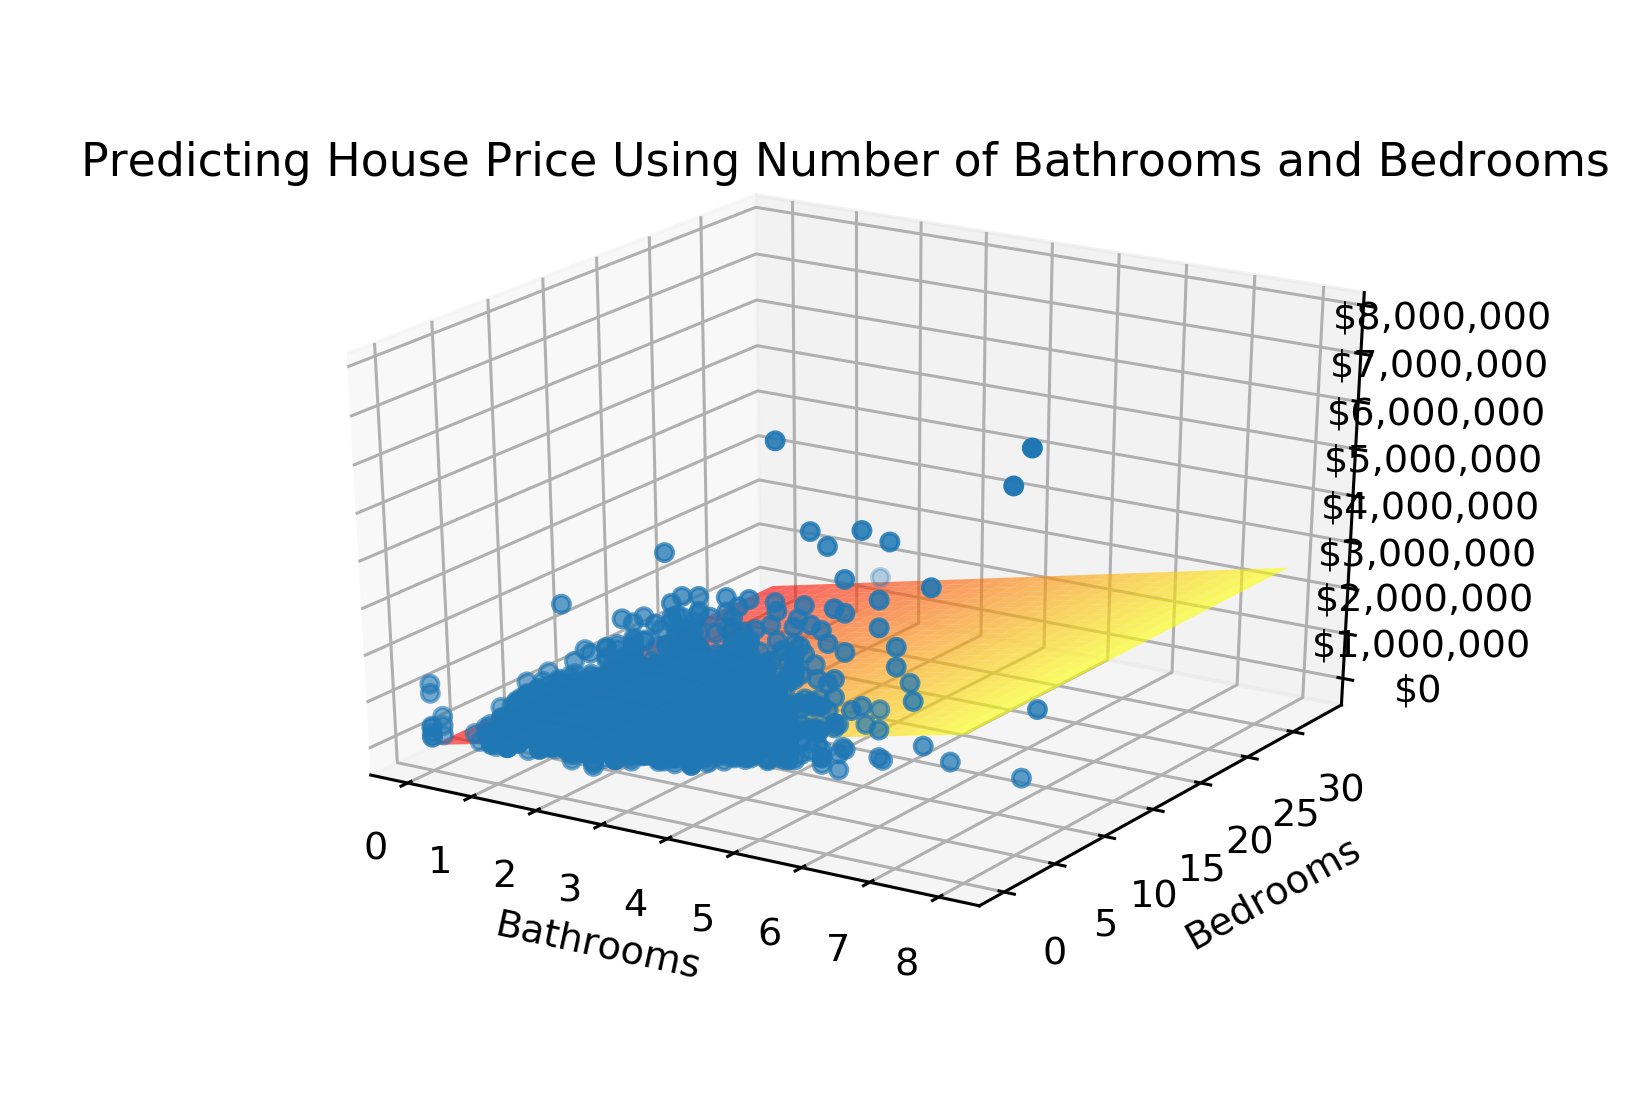

In [31]:
%matplotlib nbagg
dependent_vars2 = ['bathrooms', 'bedrooms']
feats2 = table2[dependent_vars2]
lab2 = table2['price']
weights2 = linear_regression(feats2, lab2)      #Compute linear regression weights

#Make sample input data:
xranges2 = []
for col in feats2.columns:
    sample2 = np.linspace(min(feats2[col].values), max(feats2[col].values), 30)
    xranges2.append(sample2)

xrange2 = np.matrix(xranges2).transpose()
xrange2 = np.insert(xrange2, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange2.shape[1] ==  weights2.shape[0]) #Assert correct dimensioning for dot product

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

title = 'Predicting House Price Using Number of ' + dependent_vars2[0].capitalize() + ' and ' + dependent_vars2[1].capitalize()
ax.set_title(title)
ax.set_xlabel(dependent_vars2[0].capitalize())
ax.set_ylabel(dependent_vars2[1].capitalize())
ax.w_zaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

ax.scatter(feats2[dependent_vars2[0]], feats2[dependent_vars2[1]], lab2)

feat1, feat2 = np.meshgrid(np.asarray(xrange2[:, 1]), np.asarray(xrange2[:, 2]))
ax.plot_surface(feat1, feat2, np.asarray((xrange2 * weights2).flatten())[0], alpha=.6, cmap=cm.autumn);

As expected, we can see that there is a positive correlation between number of bedrooms / bathrooms and price. The much larger bathroom coefficient could be explained by a number of factors:
- The possible range of bedrooms is much higher than bathrooms, and so bathrooms are more valued per unit (bedrooms could be a variable that includes non-bedroom/non-bathroom rooms) 
- The cost of building a bathroom include most of the costs of a bedroom (door(s), windows) but also include significant costs such as plumbing and ventilitation
- Having an excessive number of bathrooms is a luxury correlated with especially expensive homes

In [32]:
print('Bias:', '${:0.3f}'.format(weights2.item(0, 0)))
print(dependent_vars2[0].capitalize(), 'coefficient:', '${:0.3f}'.format(weights2.item(1, 0)))
print(dependent_vars2[1].capitalize(), 'coefficient:', '${:0.3f}'.format(weights2.item(2, 0)))

Bias: $-30642.996
Bathrooms coefficient: $237780.585
Bedrooms coefficient: $20138.266


In [33]:
feat_mat2 = np.insert(np.matrix(feats2), 0, 1, axis=1) # Add bias input
predicted2 = feat_mat2 * weights2
r2 = r_squared(np.asarray(predicted2.transpose())[0], np.array(lab2))
sse = sum_squared_error(np.asarray(predicted2.transpose())[0], np.array(lab2))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table2)))
print('mean error is ${:0.4f}'.format((sse/len(table2))**.5))

r squared is 0.2777
sum squared error is 2104059567598698.0000
mean squared error is 97351573941.5490
mean error is $312012.1375


### Scikit-learn comparison

In [34]:
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats2, lab2)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
sc_linear_predictions = feat_mat2 * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab2), np.array(sc_linear_predictions).transpose()[0])
print('scikit-learn predicted r squared {:0.4f}'.format(sc_linear_r2))

scikit-learn predicted r squared 0.2777


### RMSProp

Here we run a linear RMSProp approximation (as with the GDP data) using the manually chosen features:

151 iterations
weights: [[  46170.55401446  148832.9493722    54707.27418905]]
r squared is 0.2518
sum squared error is 2179301684453792.2500
mean squared error is 100832910028.8619
mean error is $317541.9815


<IPython.core.display.Javascript object>


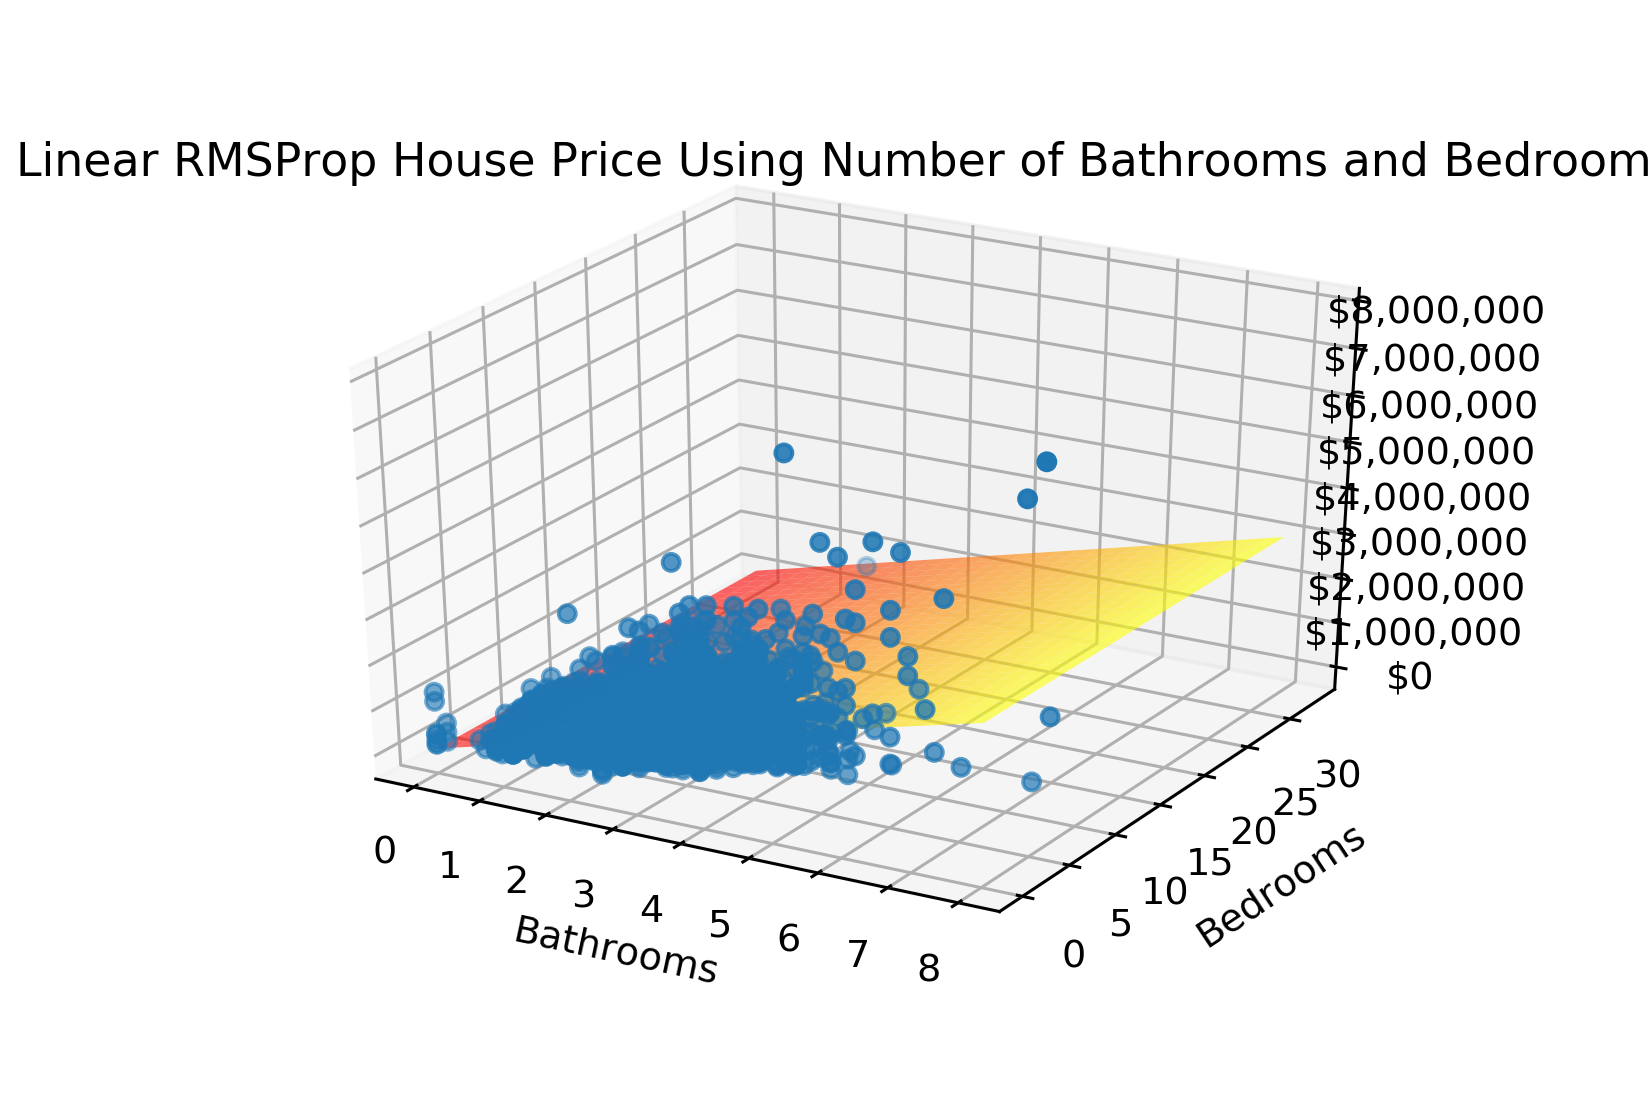

In [35]:
%matplotlib nbagg
weights2_rms_prop = linear_rms_prop(feats2, lab2, 1000, int(len(table2)/5), decay_rate=.01,
                                    epsilon=1.09*(10**15), epsilon_delta=.0001, max_iter=1000)
print('weights:', weights2_rms_prop.transpose())
feat_mat2 = np.insert(np.matrix(feats2), 0, 1, axis=1) # Add bias input
predicted2 = feat_mat2 * weights2_rms_prop
r2 = r_squared(np.asarray(predicted2.transpose())[0], np.array(lab2))
sse = sum_squared_error(np.asarray(predicted2.transpose())[0], np.array(lab2))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table2)))
print('mean error is ${:0.4f}'.format((sse/len(table2))**.5))

#Make sample input data:
xranges2 = []
for col in feats2.columns:
    sample2 = np.linspace(min(feats2[col].values), max(feats2[col].values), 30)
    xranges2.append(sample2)

xrange2 = np.matrix(xranges2).transpose()
xrange2 = np.insert(xrange2, 0, 1, axis=1)     #Add constant bias input to first column
assert(xrange2.shape[1] ==  weights2_rms_prop.shape[0]) #Assert correct dimensioning for dot product

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

title = 'Linear RMSProp House Price Using Number of ' + dependent_vars2[0].capitalize() + ' and ' + dependent_vars2[1].capitalize()
ax.set_title(title)
ax.set_xlabel(dependent_vars2[0].capitalize())
ax.set_ylabel(dependent_vars2[1].capitalize())
ax.w_zaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))

ax.scatter(feats2[dependent_vars2[0]], feats2[dependent_vars2[1]], lab2)

feat1, feat2 = np.meshgrid(np.asarray(xrange2[:, 1]), np.asarray(xrange2[:, 2]))
ax.plot_surface(feat1, feat2, np.asarray((xrange2 * weights2_rms_prop).flatten())[0], alpha=.6, cmap=cm.autumn);

RMSProp converges in 150 iterations (20% of the data used in each minibatch), it provides an r squared and error similar to the linear regression model. If RMSProp is forced to a greater number of iterations, it can converge to a slightly better optimum (same as that of linear regression).

## Defining Forward Stepwise Regression

Before moving on to multivariate linear regression of more than two variables we will define a simple algorithm that lets us iteratively choose a set of good regressors. Stepwise regression begins with the set of all possible regressors and an empty set of chosen regressors. At each iteration, stepwise regression adds to the chosen regressors set by adding the regressor that improves the regression the most. Iterations continue as long as the addition of one of the regressors improves the regression above a threshold performance metric. Here we use r squared as that metric.

The thresh_comparison paramter is initialized to the starting value of the metric we compare the candidates to. The default is small because single features on their own may not be very good. A new feature will only be added if it improves the existing set by the thresh value (if it set to zero, an added feature merely needs to not worsen model to be added):

In [36]:
def forward_stepwise_regression(feature_df, label_series, regress=linear_regression, metric=r_squared,
                                thresh_comparison=-.1, thresh=.01):
    possible = list(feature_df.columns)
    chosen = []
    above_threshold = True
    
    while (above_threshold and possible):
        weight_dict = {feat: regress(feature_df[chosen + [feat]], label_series) for feat in possible}
        feat_mat_dict = {feat: np.insert(np.matrix(feature_df[chosen + [feat]]), 0, 1, axis=1) for feat in possible}
        
        predict_dict = {feat: feat_mat_dict[feat] * weight_dict[feat] for feat in possible}
        score_dict = {feat: metric(np.asarray(predict_dict[feat].transpose())[0], np.array(label_series)) for feat in possible}

        best_feat = max(score_dict, key=score_dict.get)    
        if (score_dict[best_feat] >= (thresh_comparison + thresh)):
            thresh_comparison = score_dict[best_feat]
            chosen.append(best_feat)
            possible.remove(best_feat)
        else:
            above_threshold = False
    return chosen

## Multivariate Linear Regression

Below we run stepwise regression with the [King County](https://www.kaggle.com/harlfoxem/housesalesprediction) dataset with more than two possible numerical variables:

In [37]:
quantitative_feats = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated',  'sqft_living15', 'sqft_lot15']
feats2_sw = table2[quantitative_feats]
lab2_sw = table2['price']
best2 = forward_stepwise_regression(feats2_sw, lab2_sw)

weights2_sw = linear_regression(feats2_sw[best2], lab2_sw)          #Compute linear regression weights
feat_mat2_sw = np.insert(np.matrix(feats2_sw[best2]), 0, 1, axis=1) # Add bias input
predicted2_sw = feat_mat2_sw * weights2_sw
r2 = r_squared(np.asarray(predicted2_sw.transpose())[0], np.array(lab2_sw))
sse = sum_squared_error(np.asarray(predicted2_sw.transpose())[0], np.array(lab2_sw))
print('chosen:', ', '.join(best2))
if (best2):
    print('\nr squared: {:0.4f}'.format(r2))
    print('sum squared error is {:0.4f}'.format(sse))
    print('mean squared error is {:0.4f}'.format(sse/len(table2)))
    print('mean error is ${:0.4f}'.format((sse/len(table2))**.5))

chosen: sqft_living, yr_built, bedrooms, bathrooms, sqft_living15

r squared: 0.5617
sum squared error is 1276697328874028.5000
mean squared error is 59070805944.2941
mean error is $243044.8641


We find that we manually chose two of the features in the previous section that are found by stepwise regression.

In [38]:
print('Bias:', '${:0.3f}'.format(weights2_sw.item(0, 0)))
for i in range(len(best2)):
    print(best2[i].capitalize(), 'coefficient:', '${:0.3f}'.format(weights2_sw.item(i+1, 0)))

Bias: $6389817.775
Sqft_living coefficient: $247.744
Yr_built coefficient: $-3298.787
Bedrooms coefficient: $-66127.647
Bathrooms coefficient: $87945.194
Sqft_living15 coefficient: $87.507


### Scikit-learn comparison

In [39]:
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats2_sw[best2], lab2_sw)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
sc_linear_predictions = feat_mat2_sw * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab2_sw), np.array(sc_linear_predictions).transpose()[0])
print('scikit-learn predicted r squared {:0.4f}'.format(sc_linear_r2))

scikit-learn predicted r squared 0.5617


### RMSProp

In [40]:
weights2_sw_rms_prop = linear_rms_prop(feats2_sw[best2], lab2_sw, .99, int(len(table2)/5), decay_rate=.01,
                                    epsilon=7.3*(10**14), epsilon_delta=.1, max_iter=1000)
print('weights:', weights2_sw_rms_prop.transpose())
feat_mat2_sw = np.insert(np.matrix(feats2_sw[best2]), 0, 1, axis=1) # Add bias input
predicted2_sw = feat_mat2_sw * weights2_sw_rms_prop
r2 = r_squared(np.asarray(predicted2_sw.transpose())[0], np.array(lab2_sw))
sse = sum_squared_error(np.asarray(predicted2_sw.transpose())[0], np.array(lab2_sw))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table2)))
print('mean error is ${:0.4f}'.format((sse/len(table2))**.5))

234 iterations
weights: [[ -38.53193678  214.41550525  -44.36263167  -39.1402442   135.52819304
    92.61372484]]
r squared is 0.4988
sum squared error is 1459847093717848.7500
mean squared error is 67544861598.0127
mean error is $259893.9430


The coefficients are different from linear regression, but their signs are the same and the calculated error is not far off from linear regression. With more tuning, we could probably acheive an error that more closely matches the analytical linear regression model.

### [Melbourne Housing Market](https://www.kaggle.com/anthonypino/melbourne-housing-market)

The following is another housing dataset from Kaggle, this time describing the housing market in Melbourne, Australia. The data is from mid 2016 to early 2017. It contains a few different types of data from the King County dataset, including some categoricals for variables such as the suburb, property type, and council area. We'll use this dataset for multivariate stepwise regression and see if we can compare the results to the King County dataset used previously:

In [41]:
table3 = pd.read_csv('./data/Melbourne_housing_extra_data.csv')
print(len(table3), 'rows total')
print(table3.columns)
table3.head()

12109 rows total
Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude'],
      dtype='object')


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude
0,Abbotsford,68 Studley St,2.0,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,2.0,1.0,1.0,126.0,NaN,NaN,Yarra,-37.8014,144.9958
1,Abbotsford,85 Turner St,2.0,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984
2,Abbotsford,25 Bloomburg St,2.0,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934
3,Abbotsford,18/659 Victoria St,3.0,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,3.0,2.0,1.0,0.0,NaN,NaN,Yarra,-37.8114,145.0116
4,Abbotsford,5 Charles St,3.0,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944


In [42]:
quantitative_feats = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
of_interest = quantitative_feats + ['Price']
table3_clean = table3[of_interest].dropna(axis=0, how='any') #remove missing data rows

feats3_sw = table3_clean[quantitative_feats]
lab3_sw = table3_clean['Price']
best3 = forward_stepwise_regression(feats3_sw, lab3_sw)

weights3_sw = linear_regression(feats3_sw[best3], lab3_sw)          #Compute linear regression weights
feat_mat3_sw = np.insert(np.matrix(feats3_sw[best3]), 0, 1, axis=1) # Add bias input
predicted3_sw = feat_mat3_sw * weights3_sw
r2 = r_squared(np.asarray(predicted3_sw.transpose())[0], np.array(lab3_sw))
sse = sum_squared_error(np.asarray(predicted3_sw.transpose())[0], np.array(lab3_sw))

print('chosen:', ', '.join(best3))
if (best3):
    print('\nr squared: {:0.4f}'.format(r2))
    print('sum squared error is {:0.4f}'.format(sse))
    print('mean squared error is {:0.4f}'.format(sse/len(table3)))
    print('mean error is ${:0.4f}'.format((sse/len(table3))**.5))

chosen: Rooms, BuildingArea, YearBuilt, Bathroom, Distance

r squared: 0.5627
sum squared error is 826690877781043.5000
mean squared error is 68270780228.0158
mean error is $261286.7778


In [43]:
print('Bias:', '${:0.3f}'.format(weights3_sw.item(0, 0)))
for i in range(len(best2)):
    print(best3[i].capitalize(), 'coefficient:', '${:0.3f}'.format(weights3_sw.item(i+1, 0)))

Bias: $9541087.525
Rooms coefficient: $196002.074
Buildingarea coefficient: $1775.874
Yearbuilt coefficient: $-4819.931
Bathroom coefficient: $289256.796
Distance coefficient: $-30006.493


There are a number of interesting facts we get from this result. First we notice that the $r^{2}$ values of both models are about the same. Also (unsurprisingly) the features both models use are very similar. Both forward stepwise regressions found that building/house size metrics and the year built are good features for instance. The relative coefficient sizes are also similar, for example the number of bathrooms was the largest coefficient of both models. The reason that this coefficent has a higher value than that of rooms/bedrooms could be because there is less possible variation in bathrooms than there is in rooms/bedrooms.

Of course, the datasets are quite different even though they are in the same general category of housing data. Here are some of the key differences:
- The Melbourne data contains rows with missing data (which we did not attempt to fix for the purposes of this notebook - we just dropped them)
- The Melbourne data contains 'sale metadata' - variable such as real estate agent associated with the sale ('SellerG') and even how the house was sold ('Method')
- The Melbourne data is in a sense broader than the King County data - for instance it contains things like sale metadata and building type data ('Type')
- The Melbourne data contains significantly more categorical data than the King County set

For the last part of this notebook, we will address some of the last few points by defining a function to convert categorical data to a numerical encoding (ie dummy variables) that can be used with linear regression. Next we will test our performance with the Melbourne data after using one or more of the categorical variables with the optimal numerical variables that forward stepwise regression chose.

### Scikit-learn comparison

In [44]:
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats3_sw[best3], lab3_sw)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
sc_linear_predictions = feat_mat3_sw * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab3_sw), np.array(sc_linear_predictions).transpose()[0])
print('scikit-learn predicted r squared {:0.4f}'.format(sc_linear_r2))

scikit-learn predicted r squared 0.5627


### RMSProp

In [45]:
weights3_sw_rms_prop = linear_rms_prop(feats3_sw[best3], lab3_sw, 30, int(len(table3)/5), decay_rate=.01,
                                    epsilon=5*(10**14), epsilon_delta=.01, max_iter=5000)
print('weights:', weights3_sw_rms_prop.transpose())
feat_mat3_sw = np.insert(np.matrix(feats3_sw[best3]), 0, 1, axis=1) # Add bias input
predicted3_sw = feat_mat3_sw * weights3_sw_rms_prop
r2 = r_squared(np.asarray(predicted3_sw.transpose())[0], np.array(lab3_sw))
sse = sum_squared_error(np.asarray(predicted3_sw.transpose())[0], np.array(lab3_sw))
print('r squared is {:0.4f}'.format(r2))
print('sum squared error is {:0.4f}'.format(sse))
print('mean squared error is {:0.4f}'.format(sse/len(table3)))
print('mean error is ${:0.4f}'.format((sse/len(table3))**.5))

5000 iterations
weights: [[   1598.32131494  129941.41658807    2769.63498622     167.98622903
   136978.78187542  -28112.16629854]]
r squared is 0.4577
sum squared error is 1025199390406993.5000
mean squared error is 84664248939.3834
mean error is $290971.2167


The accuracy of the RMSProp model on the Melbourne data performs comparably worse than that of the King County data. Here we can see how much more difficult hyperparameter tuning can become as we increase dimensionality. With more work, it may be possible to tune the model to converge faster.

However, even though the result gained is not very close to the linear regression, the coefficients make more sense overall:

  Coefficient       |  Linear Reg   | LinearRMSProp
  -------------     | ------------- | -------------
  **Bias**          | Positive      | Positive
  **Rooms**         | Positive      | Positive
  **Buildingarea**  | Positive      | Positive
  **Yearbuilt**     | *Negative*    | Positive
  **Bathroom**      | Positive      | Positive
  **Distance**      | *Positive*    | Negative
  
As can be seen, the linear RMSProp model has a result that confirms expectations we would have across all factors. In the linear regression model year built has a negative correlation to price (newer houses cost less according to the model) and a greater distance from the CBD or "Central Business District" *increases* the price. In the linear rmpsprop model, these correlations are reversed as would be expected.

## Multivariate Linear Regression Including Categoricals

The first thing we will do is define a function to convert a categorical column of data into a dummy variable (one hot encoded) respresentation. This works fine for both nominal and ordinal categorical data. In this dummying function, I also remove categorical values that have the highest possible level of infrequency (they appear only once):

In [46]:
def one_hot_encoding(series):
    baseline = series.value_counts().idxmax() # Find most common value and make it the baseline
    value_set = list(series.unique())
    value_set.remove(baseline)

    df = pd.DataFrame(series)
    for value_name in value_set:
        df[series.name +'_' +str(value_name)] = (df[series.name] == value_name).astype(int)
    
    # Remove categorical values with a frequency count of 1 (lowest possible frequency)
    least_freq = series.value_counts()[series.value_counts() == 1].index.tolist()
    to_drop = [series.name + '_' + str(val_name) for val_name in least_freq]
    df.drop(to_drop, axis=1, inplace=True)
    
    return df.iloc[:, 1:] # Don't return the original column

### Melbourne Data

Here we perform the same stepwise regression with the Melbourne data as before, but manually include categorical 'Suburb', 'Type', 'Method', and 'SellerG data as dummy one hot encoded columns. First we use all three in the regression, then we run each regression separately:

In [47]:
quantitative_feats_c = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']
categorical_feats_c = ['Suburb', 'Type', 'Method', 'SellerG']
of_interest_c = quantitative_feats_c + categorical_feats_c + ['Price']
table3_clean_c = table3[of_interest_c].dropna(axis=0, how='any') # remove missing data rows

feats3_sw = table3_clean[quantitative_feats_c]
lab3_swc = table3_clean_c['Price']
best3 = forward_stepwise_regression(feats3_sw, lab3_swc, thresh_comparison=-1, thresh=.01)

dummies = [one_hot_encoding(table3_clean_c[categorical]) for categorical in categorical_feats_c]
dummy_names = [list(dummy.columns) for dummy in dummies]
all_dummy_names = []
for dummy_name_list in dummy_names:
    all_dummy_names.extend(dummy_name_list)
assert(len(all_dummy_names) == len(set(all_dummy_names))) # Assert no duplicate categorical column dummy names

feats3_swc = feats3_sw.copy()
for dummy_categorical_df in dummies:
    feats3_swc = feats3_swc.join(dummy_categorical_df)

# All Categoricals
weights3_swc = linear_regression(feats3_swc[best3 + all_dummy_names], lab3_swc)     # Compute linear regression weights
feat_mat3_swc = np.insert(np.matrix(feats3_swc[best3 + all_dummy_names]), 0, 1, axis=1)   # Add bias input
predicted3_swc = feat_mat3_swc * weights3_swc
r2 = r_squared(np.asarray(predicted3_swc.transpose())[0], np.array(lab3_swc))
sse = sum_squared_error(np.asarray(predicted3_swc.transpose())[0], np.array(lab3_swc))
print('regression with all categoricals r squared: {:0.4f}'.format(r2))
print('regression with all categoricals sum squared error: {:0.4f}'.format(sse))
print('regression with all categoricalsmean squared error: {:0.4f}'.format(sse/len(table3)))
print('regression with all categoricals mean error: ${:0.4f}'.format((sse/len(table3))**.5))
print()

# Each Categorical
for i in range(len(categorical_feats_c)):
    weights3_swc = linear_regression(feats3_swc[best3 + dummy_names[i]], lab3_swc)     # Compute linear regression weights
    feat_mat3_swc = np.insert(np.matrix(feats3_swc[best3 + dummy_names[i]]), 0, 1, axis=1)   # Add bias input
    predicted3_swc = feat_mat3_swc * weights3_swc
    r2 = r_squared(np.asarray(predicted3_swc.transpose())[0], np.array(lab3_swc))
    print('regression with', categorical_feats_c[i], 'categorical r squared: {:0.4f}'.format(r2))

regression with all categoricals r squared: 0.7501
regression with all categoricals sum squared error: 472399672839241.7500
regression with all categoricalsmean squared error: 39012277879.2007
regression with all categoricals mean error: $197515.2599

regression with Suburb categorical r squared: 0.7006
regression with Type categorical r squared: 0.5737
regression with Method categorical r squared: 0.5670
regression with SellerG categorical r squared: 0.6425


We can see that adding the Suburb and SellerG categoricals significantly improve $r^{2}$ while Type and Method increases $r^{2}$ to a lesser degree. This makes sense because Suburb and SellerG both provide data that is very specific to Melbourne (the Suburb and real estate agent of the house sale). This type of data is obviously very biased to the Melbourne housing and if this were attempting to be a general model of a larger area, the model would definately be overfit to Melbourne. The Method variable is not as performant, but is general enough to be used for other areas beside Melbourne. Of course, in this application we are not concerned with generalizing outside of Melbourne, so using these categoricals is permissible.

### Scikit-learn comparison

In [48]:
# All Categoricals
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats3_swc[best3 + all_dummy_names], lab3_swc)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
feat_mat3_swc = np.insert(np.matrix(feats3_swc[best3 + all_dummy_names]), 0, 1, axis=1)   # Add bias input
sc_linear_predictions = feat_mat3_swc * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab3_swc), np.array(sc_linear_predictions).transpose()[0])
print('regression with all categoricals scikit-learn predicted r squared: {:0.4f}'.format(sc_linear_r2))

# Each Categorical
for i in range(len(categorical_feats_c)):
    sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
    sc_linear_reg.fit(feats3_swc[best3 + dummy_names[i]], lab3_swc)
    sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
    feat_mat3_swc = np.insert(np.matrix(feats3_swc[best3 + dummy_names[i]]), 0, 1, axis=1)   # Add bias input
    sc_linear_predictions = feat_mat3_swc * sc_linear_model_weights
    sc_linear_r2 = r2_score(np.array(lab3_swc), np.array(sc_linear_predictions).transpose()[0])
    print('regression with', categorical_feats_c[i], 'scikit-learn predicted r squared: {:0.4f}'.format(sc_linear_r2))

regression with all categoricals scikit-learn predicted r squared: 0.7501
regression with Suburb scikit-learn predicted r squared: 0.7006
regression with Type scikit-learn predicted r squared: 0.5737
regression with Method scikit-learn predicted r squared: 0.5670
regression with SellerG scikit-learn predicted r squared: 0.6425


### RMSProp

Lets run Linear RMSProp with all the best numericals and all the categorical columns:

In [49]:
weights3_swc_sw_rms_prop = linear_rms_prop(feats3_swc[best3 + all_dummy_names], lab3_swc, 80, int(len(table3)/5), decay_rate=.01,
                                    epsilon=1*(10**14), epsilon_delta=.1, max_iter=5000)
feat_mat3_swc = np.insert(np.matrix(feats3_swc[best3 + all_dummy_names]), 0, 1, axis=1)   # Add bias input
predicted3_swc = feat_mat3_swc * weights3_swc_sw_rms_prop
r2 = r_squared(np.asarray(predicted3_swc.transpose())[0], np.array(lab3_swc))
sse = sum_squared_error(np.asarray(predicted3_swc.transpose())[0], np.array(lab3_swc))
print('RMSProp with all categoricals r squared is {:0.4f}'.format(r2))
print('regression with all categoricals sum squared error: {:0.4f}'.format(sse))
print('regression with all categoricalsmean squared error: {:0.4f}'.format(sse/len(table3)))
print('regression with all categoricals mean error: ${:0.4f}'.format((sse/len(table3))**.5))

5000 iterations
RMSProp with all categoricals r squared is 0.6361
regression with all categoricals sum squared error: 688007554521944.2500
regression with all categoricalsmean squared error: 56817867249.3141
regression with all categoricals mean error: $238364.9875


With the large amount of features, linear RMSProp performs reasonably well, but still not as well as the analytical solution to linear regression. I was not able to optimize the hyperparameters to have the model to converge before the 5000 iteration limit. With more tweaking it can probably be done.

### King County Data

For the purposes of continuity, lets repeat the process above with the King County dataset. The categoricals we will look at here are all numeric, however they cannot be treated as quantitative values because they don't have such a meaning. The 'waterfront' is a boolean that tells us whether the house is a waterfront home. The 'view', 'condition', and 'grade' variables are ordinal categorical variables. Because 'waterfront' is already a boolean variable, it actually does not need to be dummied, but we'll do it here for naming consistency for the categorical data.

In [50]:
quantitative_feats_c = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot', 'floors', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated',  'sqft_living15', 'sqft_lot15']
categorical_feats_c = ['waterfront', 'view', 'condition', 'grade']
feats2_sw = table2[quantitative_feats_c]
lab2_swc = table2['price']
best2 = forward_stepwise_regression(feats2_sw, lab2_swc)

dummies = [one_hot_encoding(table2[categorical]) for categorical in categorical_feats_c]
dummy_names = [list(dummy.columns) for dummy in dummies]

all_dummy_names = []
for dummy_name_list in dummy_names:
    all_dummy_names.extend(dummy_name_list)
assert(len(all_dummy_names) == len(set(all_dummy_names))) # Assert no duplicate categorical column dummy names

feats2_swc = feats2_sw.copy()
for dummy_categorical_df in dummies:
    feats2_swc = feats2_swc.join(dummy_categorical_df)

# All Categoricals
weights2_swc = linear_regression(feats2_swc[best2 + all_dummy_names], lab2_swc)     # Compute linear regression weights
feat_mat2_swc = np.insert(np.matrix(feats2_swc[best2 + all_dummy_names]), 0, 1, axis=1)   # Add bias input
predicted2_swc = feat_mat2_swc * weights2_swc
r2 = r_squared(np.asarray(predicted2_swc.transpose())[0], np.array(lab2_swc))
sse = sum_squared_error(np.asarray(predicted2_swc.transpose())[0], np.array(lab2_swc))
print('regression with all categoricals r squared: {:0.4f}'.format(r2))
print('regression with all categoricals sum squared error: {:0.4f}'.format(sse))
print('regression with all categoricalsmean squared error: {:0.4f}'.format(sse/len(table2)))
print('regression with all categoricals mean error: ${:0.4f}'.format((sse/len(table2))**.5))
print()

# Each Categorical
for i in range(len(categorical_feats_c)):
    weights2_swc = linear_regression(feats2_swc[best2 + dummy_names[i]], lab2_swc)     # Compute linear regression weights
    feat_mat2_swc = np.insert(np.matrix(feats2_swc[best2 + dummy_names[i]]), 0, 1, axis=1)   # Add bias input
    predicted2_swc = feat_mat2_swc * weights2_swc
    r2 = r_squared(np.asarray(predicted2_swc.transpose())[0], np.array(lab2_swc))
    print('regression with', categorical_feats_c[i], 'categorical r squared: {:0.4f}'.format(r2))

regression with all categoricals r squared: 0.6791
regression with all categoricals sum squared error: 934719429153744.5000
regression with all categoricalsmean squared error: 43248018745.8356
regression with all categoricals mean error: $207961.5800

regression with waterfront categorical r squared: 0.5906
regression with view categorical r squared: 0.5933
regression with condition categorical r squared: 0.5627
regression with grade categorical r squared: 0.6438


We can see that all the categoricals improve the original model. As with the Melbourne data, the more specific and involved variables improve the model further. Also like the Melbourne data, this model performs best with all possible data sources. We can see that categoricals like 'waterfront' and 'view' increase the original model by an $r^{2}$ of about .03. By contrast the 'grade' categorical improves the model the most. Of course depending on how 'grade' was determined, using it may be akin to using a handmade label as a feature to a model, which would be very practically useful. All in all, the model over the King County data does performs comparably but ultimately not as well as that of the Melbourne dataset. This is somewhat expected as the Melbourne data contains regionally biased features such as suburb location and real estage agent of the sale.

### Scikit-learn comparison

In [51]:
# All Categoricals
sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
sc_linear_reg.fit(feats2_swc[best2 + all_dummy_names], lab2_swc)
sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
feat_mat2_swc = np.insert(np.matrix(feats2_swc[best2 + all_dummy_names]), 0, 1, axis=1)   # Add bias input
sc_linear_predictions = feat_mat2_swc * sc_linear_model_weights
sc_linear_r2 = r2_score(np.array(lab2_swc), np.array(sc_linear_predictions).transpose()[0])
print('regression with all categoricals scikit-learn predicted r squared: {:0.4f}'.format(sc_linear_r2))

# Each Categorical
for i in range(len(categorical_feats_c)):
    sc_linear_reg = LinearRegression(fit_intercept=True, normalize=False)
    sc_linear_reg.fit(feats2_swc[best2 + dummy_names[i]], lab2_swc)
    sc_linear_model_weights = np.matrix(np.insert(np.array(sc_linear_reg.coef_), 0, sc_linear_reg.intercept_)).transpose()
    feat_mat2_swc = np.insert(np.matrix(feats2_swc[best2 + dummy_names[i]]), 0, 1, axis=1)   # Add bias input
    sc_linear_predictions = feat_mat2_swc * sc_linear_model_weights
    sc_linear_r2 = r2_score(np.array(lab2_swc), np.array(sc_linear_predictions).transpose()[0])
    print('regression with', categorical_feats_c[i], 'scikit-learn predicted r squared: {:0.4f}'.format(sc_linear_r2))

regression with all categoricals scikit-learn predicted r squared: 0.6791
regression with waterfront scikit-learn predicted r squared: 0.5906
regression with view scikit-learn predicted r squared: 0.5933
regression with condition scikit-learn predicted r squared: 0.5627
regression with grade scikit-learn predicted r squared: 0.6438


### RMSProp

Lets run Linear RMSProp with all the best numericals and all the categorical columns:

In [52]:
weights2_swc_sw_rms_prop = linear_rms_prop(feats2_swc[best2 + all_dummy_names], lab2_swc, .9, int(len(table2)/5), decay_rate=.01,
                                    epsilon=7*(10**14), epsilon_delta=10, max_iter=5000)
feat_mat2_swc = np.insert(np.matrix(feats2_swc[best2 + all_dummy_names]), 0, 1, axis=1)   # Add bias input
predicted2_swc = feat_mat2_swc * weights2_swc_sw_rms_prop
r2 = r_squared(np.asarray(predicted2_swc.transpose())[0], np.array(lab2_swc))
sse = sum_squared_error(np.asarray(predicted2_swc.transpose())[0], np.array(lab2_swc))
print('RMSProp with all categoricals r squared is {:0.4f}'.format(r2))
print('regression with all categoricals sum squared error: {:0.4f}'.format(sse))
print('regression with all categoricalsmean squared error: {:0.4f}'.format(sse/len(table2)))
print('regression with all categoricals mean error: ${:0.4f}'.format((sse/len(table2))**.5))

5000 iterations
RMSProp with all categoricals r squared is 0.5063
regression with all categoricals sum squared error: 1438152700896779.0000
regression with all categoricalsmean squared error: 66541095678.3778
regression with all categoricals mean error: $257955.6080


As with the Melbourne data, the King County model is hard to optimize. RMSProp is a great algorithm because of its ability to converge without exploding. The problem is that it can be succeptible to sticking to local minima and not moving much. Still, this type of behavior is often preferred to no learning at all. Certainly it is a great model for training a wide range of models and it has a realtively high performance ceiling for a wide range of data.